# Setup

In [1]:
#import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2 as cv
import math
import os
import keras_tuner
import train
import evaluate

# Dataset loading

Dataset is loaded from csv files contained in a directory, where pixel information of the images (0-255) is stored together with labels.
This loading is performed using a Trainer object, which also contains visualization methods, and performs the resizing and normalization of images.

Parameter for Trainer should be explicitely called, since it accepts several data source (pict = image array, data = image + labels array
or datapath = directory containing annotated csv files)

The Trainer default label-picture split is performed for image size of 76*82 in the dataset.
It also removes any picture labelled with a 0 (errors).

## Loading and splitting of dataset

(5131, 6233)


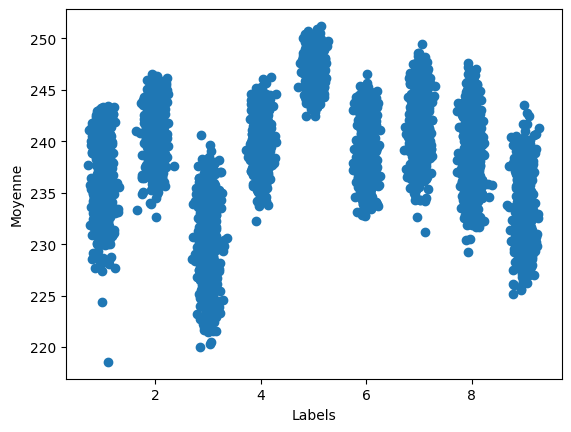

(5131, 76, 82)
(5131,)


In [2]:
train_data = train.Trainer(datapath = "data_resultsheets/Train/")
print(train_data.full_da.shape)
train_data.plot_mpi()
print(train_data.pict.shape)
print(train_data.label.shape)

(573, 6233)


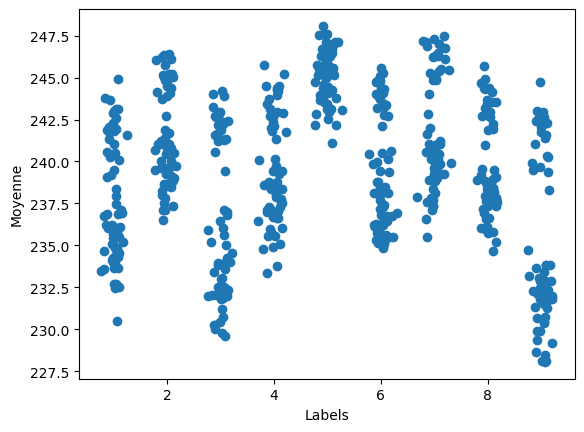

(573, 76, 82)
(573,)


In [3]:
val_data = train.Trainer(datapath = "data_resultsheets/Val/")
print(val_data.full_da.shape)
val_data.plot_mpi()
print(val_data.pict.shape)
print(val_data.label.shape)

(764, 6233)


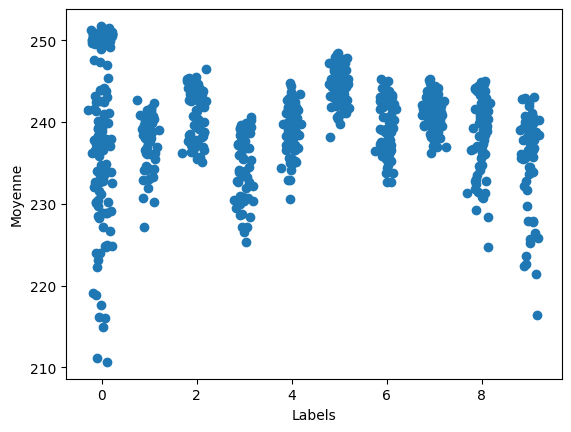

(764, 76, 82)
(764,)


In [4]:
test_data = train.Trainer(datapath = "data_resultsheets/Test/")
print(test_data.full_da.shape)
test_data.plot_mpi()
print(test_data.pict.shape)
print(test_data.label.shape)

## Picture resizing and normalization


Default resizing is to (28, 28) but one can call redimension_pict method of the object to perform resizing with another size,
this will update the pict_redim attribute.

Normalization is done by dividing by 255 (max pixel value). Resized and normalized pictures are stored in pict_redim attribute.

In [5]:
print(test_data.pict_redim.shape)
print(train_data.pict_redim.shape)
print(val_data.pict_redim.shape)
print(f'Pixel range : {train_data.pict_redim.min()} to {train_data.pict_redim.max()}')

(764, 28, 28)
(5131, 28, 28)
(573, 28, 28)
Pixel range : 0.0 to 1.0


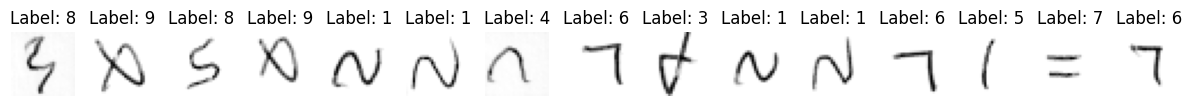

In [6]:
train_data.visualize_random_samples(pict = train_data.pict_redim, y = train_data.label, num_samples = 15)

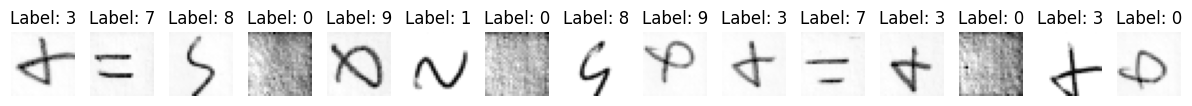

In [7]:
test_data.visualize_random_samples(pict = test_data.pict_redim, y = test_data.label, num_samples = 15)

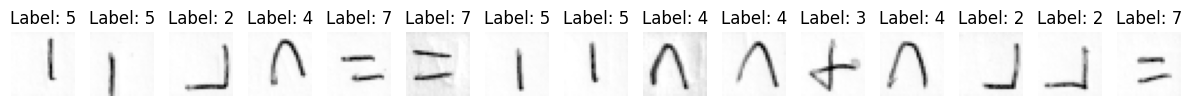

In [8]:
val_data.visualize_random_samples(pict = val_data.pict_redim, y = val_data.label, num_samples = 15)

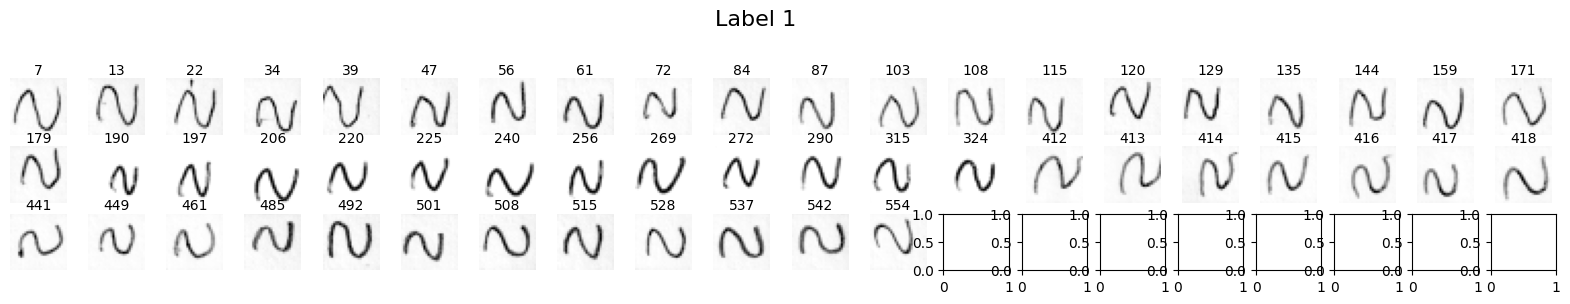

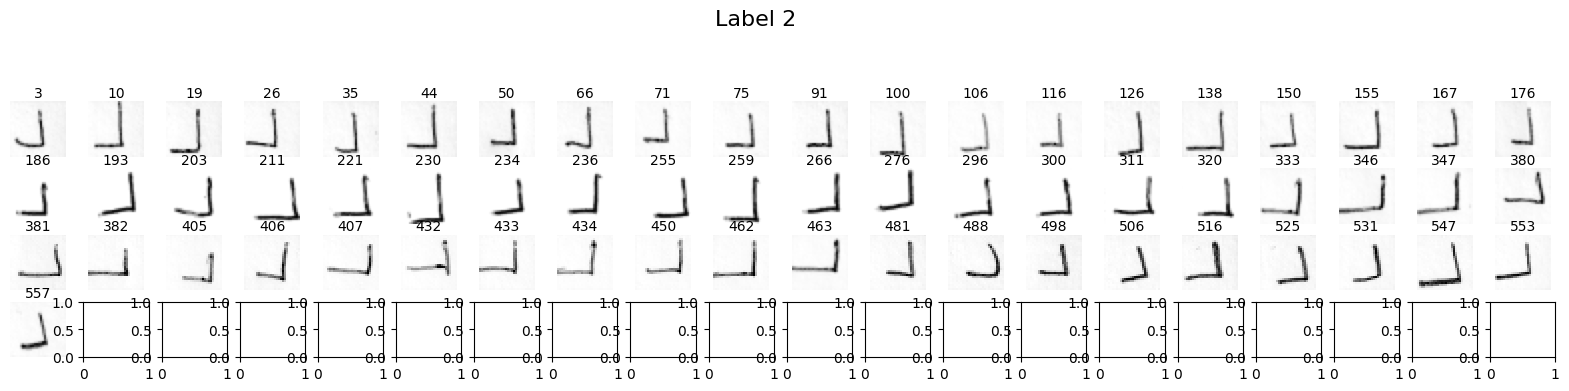

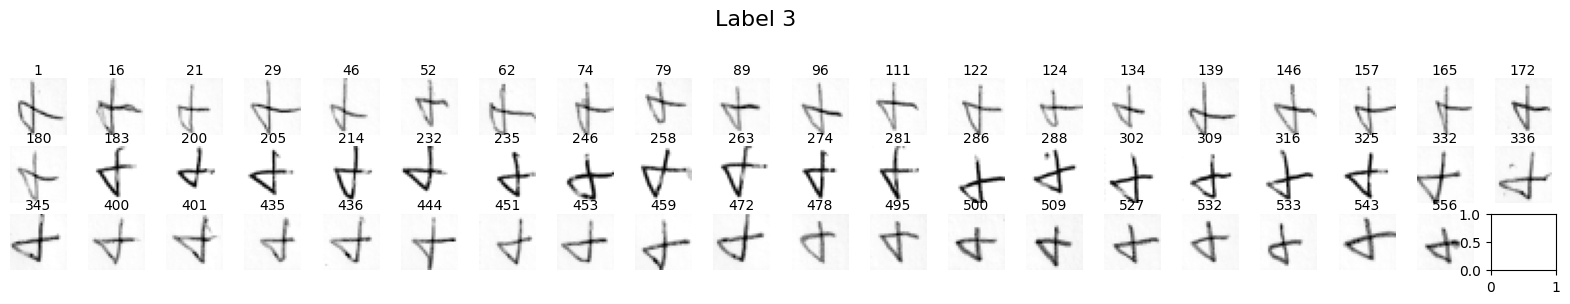

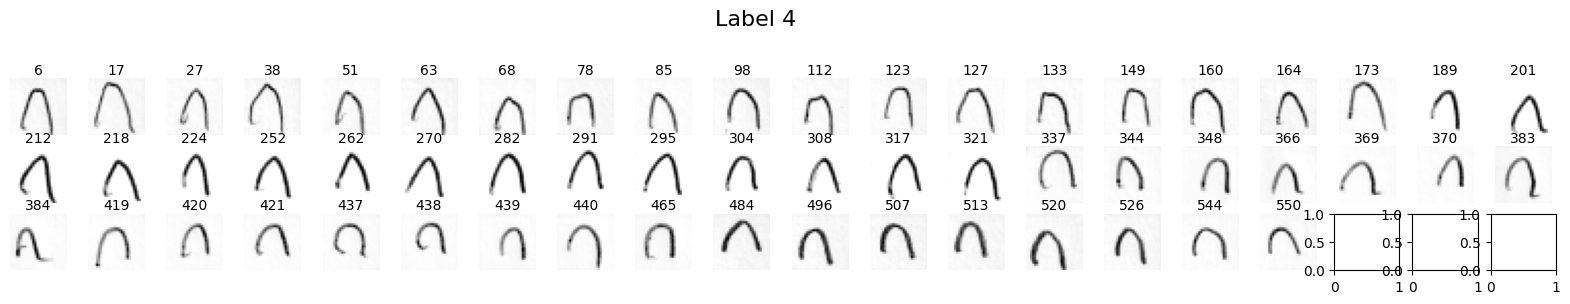

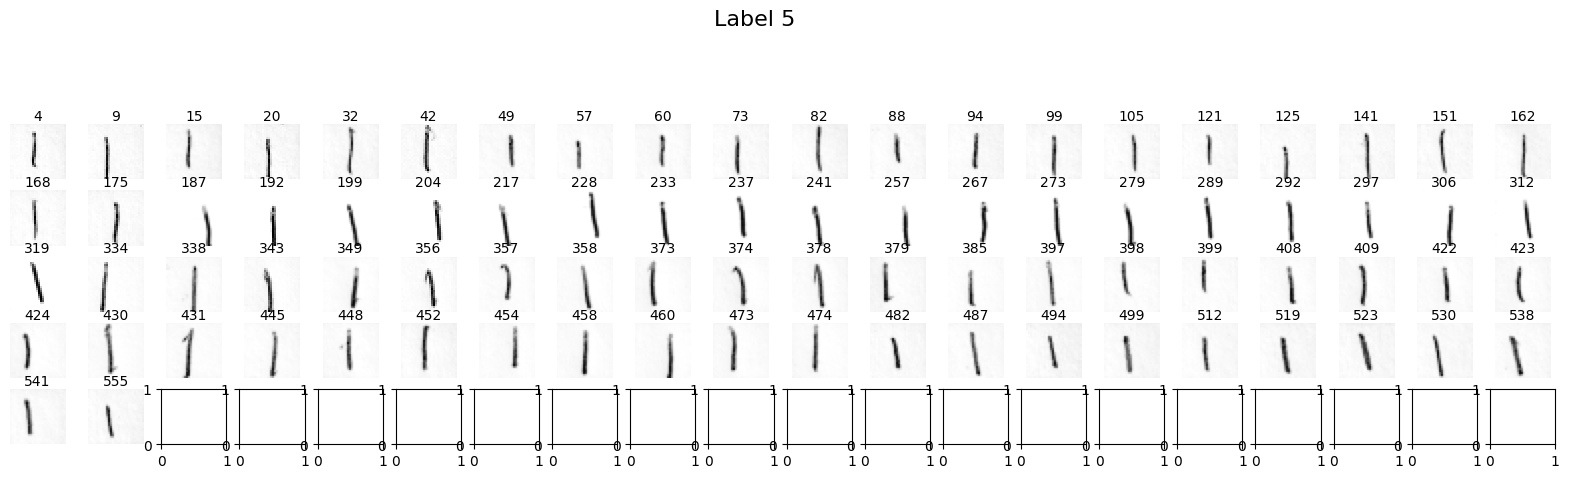

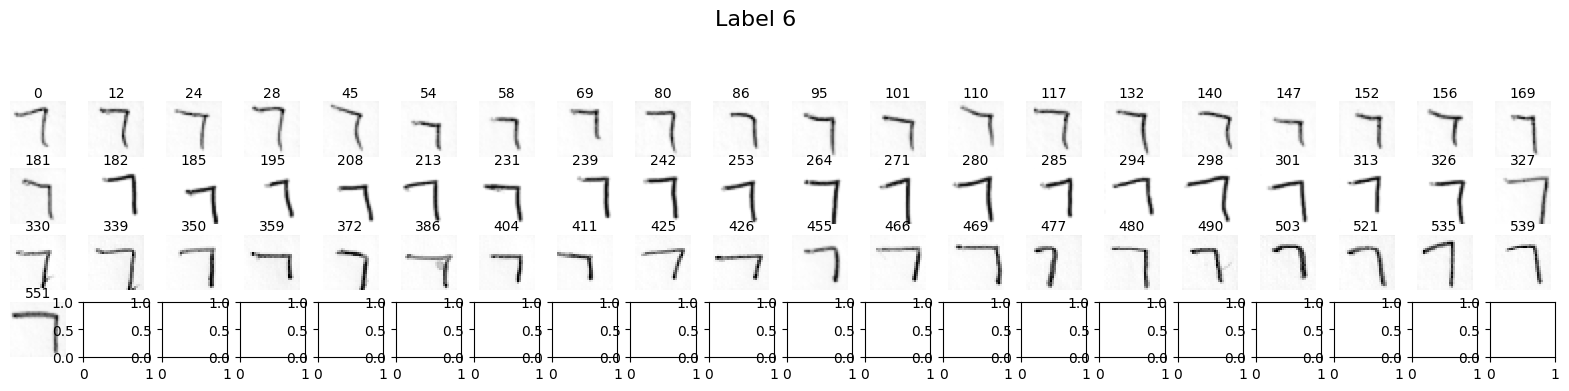

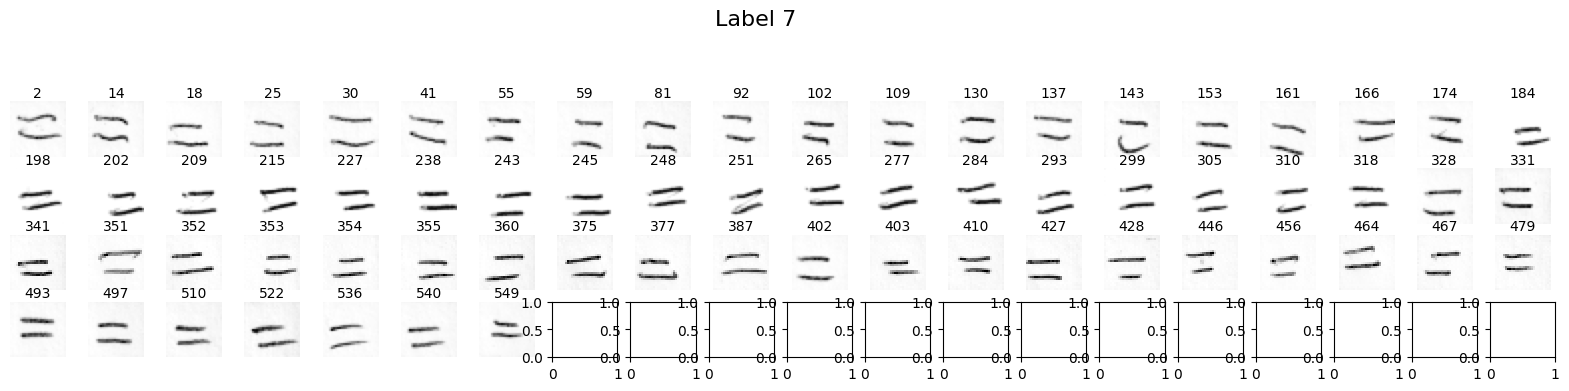

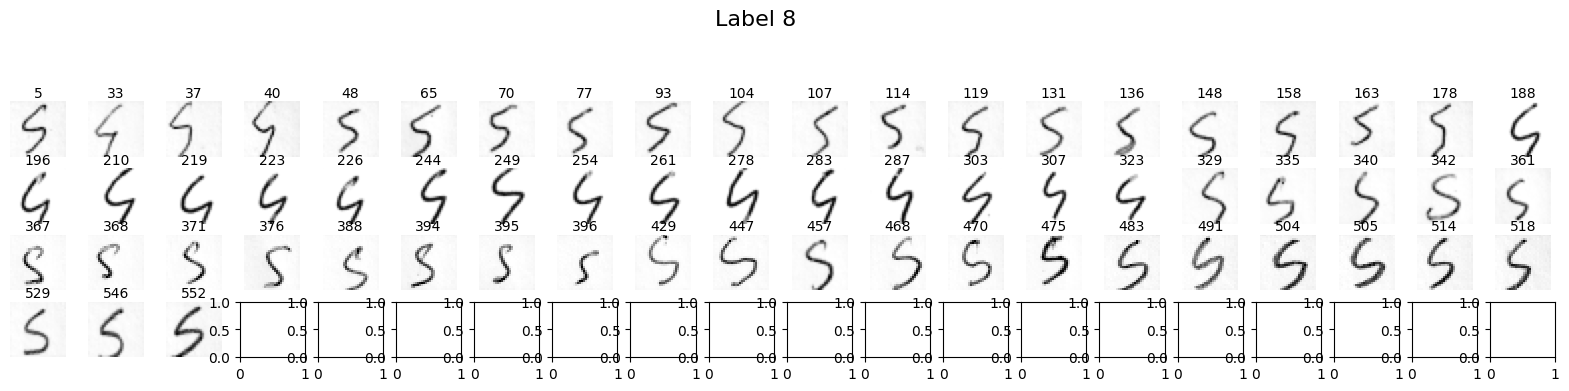

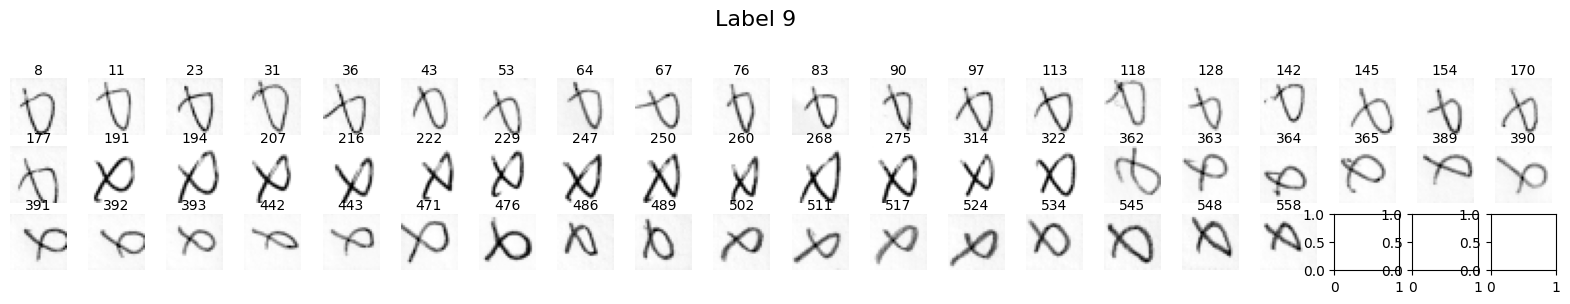

In [7]:
test_data.visualize_symbols(labels = test_data.label, imgperrow = 20)

## Train-test split

Here we use all data from train folder at training dataset, and all data from test folder as test dataset.
This can be adapted by pooling all the data and then redividing in train and test for example.

In [6]:
X_train = train_data.pict_redim
X_val = val_data.pict_redim
y_train = train_data.label
y_val = val_data.label
X_test = test_data.pict_redim
y_test = test_data.label

Training DataArray :
(5131, 28, 28)
(5131,)
Test DataArray :
(764, 28, 28)
(764,)
Val DataArray :
(573, 28, 28)
(573,)


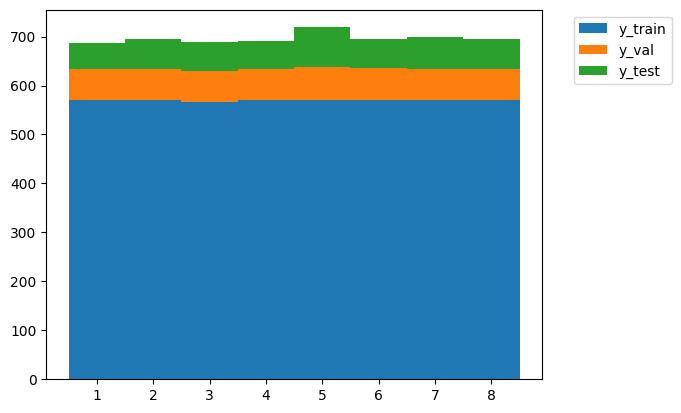

In [7]:
print("Training DataArray :")
print(X_train.shape)
print(y_train.shape)

print("Test DataArray :")
print(X_test.shape)
print(y_test.shape)

print("Val DataArray :")
print(X_val.shape)
print(y_val.shape)

plt.hist([y_train.flatten(), y_val.flatten(), y_test.flatten()], bins=np.arange(0.5, 9.5, 1), stacked=True, label=['y_train', 'y_val', 'y_test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Training of the model

## Dense Neural Network

### Hyperparameters tuning

We define a function with range of parameters to optimize, and a function to get the model with given parameters.

In [11]:
def build_model_dnn(hp):
    shape = (28,28)
    hidden1=hp.Int("units_d1", min_value=32, max_value=512, step=32)
    hidden2=hp.Int("units_d2", min_value=32, max_value=512, step=32)

    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    model = get_model_dnn(shape, hidden1, hidden2, lr)
    
    return model



In [12]:
def get_model_dnn(shape, hidden1, hidden2, lr):
    model = keras.models.Sequential([
        keras.layers.Input(shape, name='InputLayer'),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden1, activation='relu', name='Dense_n1'),
        keras.layers.Dense(hidden2, activation='relu', name='Dense_n2'),
        keras.layers.Dense(9, activation= 'softmax', name='Output')])
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate = lr),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],)
    return model

In [17]:
build_model_dnn(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_dnn,
    objective="val_acc",
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory="models/dnn_tuning",
    project_name="trec_dnn",
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_d1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_d2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [18]:
tuner.search(X_train, y_train-1, epochs=5, validation_data=(X_val, y_val-1))


Trial 50 Complete [00h 00m 12s]
val_acc: 0.7085514664649963

Best val_acc So Far: 0.7486910820007324
Total elapsed time: 00h 16m 55s


In [19]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

C:\Users\Utilisateur\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n1 (Dense)                     │ (None, 320)                 │         251,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 416)                 │         133,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 9)                   │           3,753 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 388,489 (1.48 MB)

 Trainable params: 388,489 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
tuner.results_summary()

Results summary
Results in models/dnn_tuning\trec_dnn
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 13 summary
Hyperparameters:
units_d1: 320
units_d2: 416
lr: 0.002074885608214311
Score: 0.7486910820007324

Trial 06 summary
Hyperparameters:
units_d1: 128
units_d2: 448
lr: 0.00039868977350065565
Score: 0.7260034680366516

Trial 46 summary
Hyperparameters:
units_d1: 288
units_d2: 480
lr: 0.0009507241678856559
Score: 0.7225130796432495

Trial 47 summary
Hyperparameters:
units_d1: 352
units_d2: 448
lr: 0.0014264707401098879
Score: 0.7207678854465485

Trial 49 summary
Hyperparameters:
units_d1: 224
units_d2: 192
lr: 0.0002224294479871181
Score: 0.7085514664649963

Trial 48 summary
Hyperparameters:
units_d1: 416
units_d2: 96
lr: 0.00021170184837733148
Score: 0.7033158838748932

Trial 21 summary
Hyperparameters:
units_d1: 320
units_d2: 448
lr: 0.002400263349609699
Score: 0.7024433016777039

Trial 38 summary
Hyperparameters:
units_d1: 416
units_d2: 256
lr: 0.0005334

### Model training with best hyperparameters

* With new val set
Trial 13 summary
Hyperparameters:
units_d1: 320
units_d2: 416
lr: 0.002074885608214311
Score: 0.7486910820007324

In [59]:
best_hps = tuner.get_best_hyperparameters(5)
modelDNN = build_model_dnn(best_hps[0])

In [13]:
shape = (28,28)
hidden1 = 320
hidden2 = 416
lr = 0.002074885608214311
modelDNN = get_model_dnn(shape, hidden1, hidden2, lr)

In [14]:
modelDNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n1 (Dense)                     │ (None, 320)                 │         251,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 416)                 │         133,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 9)                   │           3,753 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 388,489 (1.48 MB)

 Trainable params: 388,489 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacksDNN = [keras.callbacks.ModelCheckpoint(filepath="models/DNN_{epoch:02d}-{val_acc:.3f}.keras", monitor = 'val_acc',
                                                      save_best_only = True, mode = 'max', initial_value_threshold = 0.7),
                      keras.callbacks.EarlyStopping(monitor = 'val_acc', mode = 'max', patience=10, start_from_epoch = 15, 
                                                   restore_best_weights = True)]

In [16]:
batch_size = 32
epochs = 100

historyDNN = modelDNN.fit(
    X_train,
    y_train-1,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val-1),
    callbacks=callbacksDNN,
)


Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.1816 - loss: 2.3848 - val_acc: 0.4607 - val_loss: 1.6019
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5818 - loss: 1.1888 - val_acc: 0.4415 - val_loss: 1.6764
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7035 - loss: 0.9090 - val_acc: 0.6126 - val_loss: 1.2735
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.7742 - loss: 0.7246 - val_acc: 0.7103 - val_loss: 1.0759
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8453 - loss: 0.5457 - val_acc: 0.7504 - val_loss: 0.9911
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8483 - loss: 0.5180 - val_acc: 0.6736 - val_loss: 1.2710
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8580 - loss: 0.4841 - val_acc: 0.6946 - val_loss: 1.0827
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8752 - loss: 0.3976 - val_acc: 0.6894 - val_loss: 1.1267
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

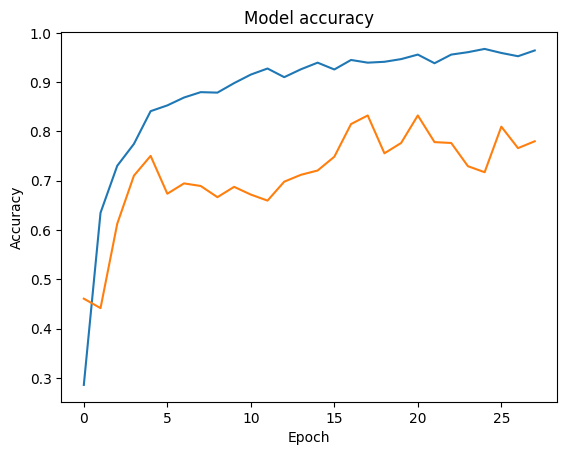

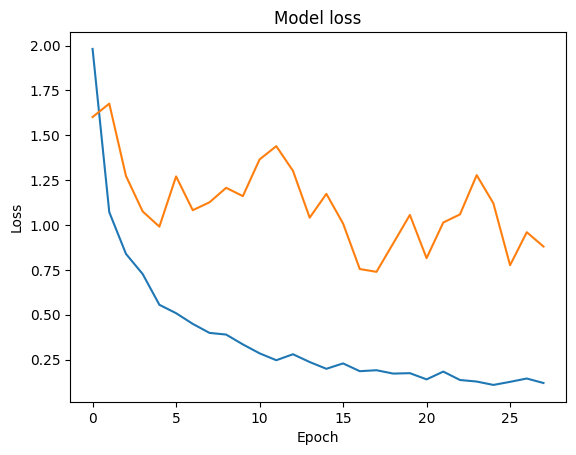

In [17]:
# Plot training & validation accuracy values
plt.plot(historyDNN.history['acc'], label = 'train')
plt.plot(historyDNN.history['val_acc'], label = 'test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(historyDNN.history['loss'], label = 'train')
plt.plot(historyDNN.history['val_loss'], label = 'test')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Convolutive Neural Network

In [8]:
x_train = X_train.reshape(-1, 28, 28, 1)
x_val = X_val.reshape(-1, 28, 28, 1)
x_test = X_test.reshape(-1, 28, 28, 1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(x_train.min(), x_train.max())

(5131, 28, 28, 1)
(573, 28, 28, 1)
(764, 28, 28, 1)
(5131,)
(573,)
(764,)
0.0 1.0


### Hyperparameter tuning

#### Step 1: model structure choice

First we will try 3 different model structure, inspired by established CNN models. The first one is the most simple with 2 convolution layers with doubling the number of filters each stage (LeNet 5). The second one has more filters and a third convolution layer. The last one uses the Conv-Conv-Pool-Conv-Conv-Pool structure (vgg like)

In [12]:
def model_choice(model_number):
    shape = (28,28,1)
    if model_number == 1:
        model = keras.models.Sequential([
            keras.layers.Input(shape, name='InputLayer'),
            keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same'),
            keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
            keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
            keras.layers.Flatten(),
            keras.layers.Dense(120, activation='relu'),
            keras.layers.Dense(84, activation='relu'),
            keras.layers.Dense(9, activation='softmax')
        ])
    if model_number == 2:
        model = keras.models.Sequential([
            keras.layers.Input(shape, name='InputLayer'),
            keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
            keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
            keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(9, activation='softmax')
        ])
    if model_number == 3:
        model = keras.models.Sequential([
            keras.layers.Input(shape, name='InputLayer'),
            keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'),
            keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'),
            keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
            keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
            keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(9, activation='softmax')
        ])
        
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate = 0.005),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],)
    return model

In [13]:
def choose_model_cnn(hp):
    choice = hp.Int("model_number", min_value=1, max_value=3, step=1)
    model = model_choice(choice)
    return model

In [14]:
choose_model_cnn(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=choose_model_cnn,
    objective="val_acc",
    max_trials=3,
    executions_per_trial=5,
    overwrite=True,
    directory="models/cnn_tuning",
    project_name="trec_cnn",
)
tuner.search_space_summary()

Search space summary
Default search space size: 1
model_number (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}


In [15]:
tuner.search(x_train, y_train-1, epochs=10, validation_data=(x_val, y_val-1))

Trial 3 Complete [00h 02m 53s]
val_acc: 0.9703315854072571

Best val_acc So Far: 0.9703315854072571
Total elapsed time: 00h 07m 10s


In [16]:
tuner.results_summary()

Results summary
Results in models/cnn_tuning\trec_cnn
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 2 summary
Hyperparameters:
model_number: 3
Score: 0.9703315854072571

Trial 1 summary
Hyperparameters:
model_number: 2
Score: 0.9082024335861206

Trial 0 summary
Hyperparameters:
model_number: 1
Score: 0.9008726119995117


It seems like third model performed the best. We will now tune its hyperparameters

#### Step 2: hyperparameters tuning

Adjusted : 
1. Number of neurons (test between 8 and 32) with second layer as double of first layer
2. Kernel size : (3,3) or (5,5) for each layer
3. Padding (with/without for each layer) and stride
4. BatchNorm and dropout



In [9]:
def build_model_cnn(hp):
    #conv1 = hp.Int("conv1", min_value=8, max_value=32, step=8)
    # k1 = hp.Int("k1", min_value=3, max_value =5, step = 2)
    # k2 = hp.Int("k2", min_value=3, max_value =5, step = 2)
    # lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # padding1 = hp.Choice("padding1", ["same", "valid"])
    # padding2 = hp.Choice("padding2", ["same", "valid"])
    # stride1 = hp.Int("s1", min_value=1, max_value =2, step = 1)
    # stride2 = hp.Int("s2", min_value=1, max_value =2, step = 1)
    # dropout1 = hp.Float("dropout1", min_value=0, max_value=0.8, step=0.1)
    # dropout2 = hp.Float("dropout2", min_value=0, max_value=0.8, step=0.1)
    # dropout3 = hp.Float("dropout3", min_value=0, max_value=0.8, step=0.1)
    # batchnorm = hp.Boolean("batchnorm")
    hidden1 = hp.Int("hidden1", min_value=150, max_value=350, step=50)
    model = get_model_cnn(hidden1)
    
    return model

In [10]:
def get_model_cnn(hidden1):
    shape = (28,28,1)
    hidden1 = 200
    lr = 0.003
    conv1 = 8
    kernel1 = (5, 5)
    kernel2 = (3, 3)
    padding1 = 'same'
    padding2 = 'valid'
    dropout1 = 0.1
    dropout2 = 0.2
    dropout3 = 0.3
    batchnorm = False

    model = keras.models.Sequential([
                keras.layers.Input(shape, name='InputLayer'),
                keras.layers.Conv2D(conv1, kernel_size=kernel1, activation='relu',padding=padding1),
                keras.layers.Conv2D(conv1, kernel_size=kernel1, activation='relu',padding=padding1)])
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(keras.layers.Dropout(dropout1))
    model.add(keras.layers.Conv2D(conv1*2, kernel_size=kernel2, activation='relu',padding=padding2))
    model.add(keras.layers.Conv2D(conv1*2, kernel_size=kernel2, activation='relu',padding=padding2))
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(keras.layers.Dropout(dropout2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(hidden1, activation='relu'))
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout3))
    model.add(keras.layers.Dense(9, activation= 'softmax', name='Output'))
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate = lr),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],)
    return model

In [113]:
build_model_cnn(keras_tuner.HyperParameters())

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_cnn,
    objective="val_acc",
    max_trials=5,
    executions_per_trial=5,
    overwrite=True,
    directory="models/cnn_tuning",
    project_name="trec_cnn",
)
tuner.search_space_summary()

Search space summary
Default search space size: 1
hidden1 (Int)
{'default': None, 'conditions': [], 'min_value': 150, 'max_value': 350, 'step': 50, 'sampling': 'linear'}


In [11]:
# Empty tensorboard logs before starting a new trial
import os, shutil
logpath = "C:/Users/Utilisateur/Documents/Stage/TREC - Codage/trec-coding/tb_logs"
for filename in os.listdir(logpath):
    file_path = os.path.join(logpath, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
logpath = "C:/Users/Utilisateur/Documents/Stage/TREC - Codage/trec-coding/tb_logs"

tuner.search(x_train, y_train-1, epochs=5, validation_data=(x_val, y_val-1),
             callbacks=[keras.callbacks.TensorBoard(logpath)])

Trial 1 Complete [00h 02m 24s]
val_acc: 0.9609075069427491

Best val_acc So Far: 0.9609075069427491
Total elapsed time: 00h 02m 24s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
350               |250               |hidden1

Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - acc: 0.4181 - loss: 1.5876 - val_acc: 0.6667 - val_loss: 1.2025
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - acc: 0.9448 - loss: 0.1659 - val_acc: 0.7295 - val_loss: 0.9664
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - acc: 0.9823 - loss: 0.0709 - val_acc: 0.8883 - val_loss: 0.3337
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - acc: 0.9905 - loss: 0.0326 - val_acc: 0.7277 - val_loss: 1.3169
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.9848 - loss: 0.0415 - val_acc: 0.9808 - val_loss: 0.0805
Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - acc: 0.5602 - loss: 1.2147 - val_acc: 0.9284 - val_loss: 0.2134
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━

In [91]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

TypeError: get_model_cnn() takes 0 positional arguments but 3 were given

In [110]:
tuner.results_summary(num_trials=30)

Results summary
Results in models/cnn_tuning\trec_cnn
Showing 30 best trials
Objective(name="val_acc", direction="max")

Trial 5 summary
Hyperparameters:
hidden1: 150
Score: 0.9534613092740377

Trial 0 summary
Hyperparameters:
hidden1: 350
Score: 0.9458987712860107

Trial 1 summary
Hyperparameters:
hidden1: 250
Score: 0.9301919539769491

Trial 3 summary
Hyperparameters:
hidden1: 400
Score: 0.9237928986549377

Trial 2 summary
Hyperparameters:
hidden1: 150
Score: 0.9232111771901449

Trial 4 summary
Hyperparameters:
hidden1: 200
Score: 0.8883071541786194

Trial 6 summary
Hyperparameters:
hidden1: 250
Score: 0.8755090037981669


### Model training with best hyperparameters

In [12]:
modelCNN = get_model_cnn(200)
modelCNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 8)           │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │          80,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 9)                   │           1,809 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,313 (341.07 KB)

 Trainable params: 87,313 (341.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
callbacksCNN = [keras.callbacks.ModelCheckpoint(filepath="models/CNN_{epoch:02d}-{val_acc:.3f}.keras", monitor = 'val_acc',
                                                      save_best_only = True, mode = 'max', initial_value_threshold = 0.7),
                      keras.callbacks.EarlyStopping(monitor = 'val_acc', mode = 'max', patience=5, start_from_epoch = 5, 
                                                   restore_best_weights = True)]

In [14]:
batch_size = 32
epochs = 50

historyCNN = modelCNN.fit(
    x_train,
    y_train-1,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val-1),
    callbacks=callbacksCNN,
)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - acc: 0.4813 - loss: 1.4171 - val_acc: 0.9459 - val_loss: 0.1718
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.9728 - loss: 0.0998 - val_acc: 0.9738 - val_loss: 0.0891
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.9805 - loss: 0.0682 - val_acc: 0.9145 - val_loss: 0.2371
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - acc: 0.9900 - loss: 0.0350 - val_acc: 0.9616 - val_loss: 0.1200
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.9917 - loss: 0.0292 - val_acc: 0.9843 - val_loss: 0.0876
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - acc: 0.9908 - loss: 0.0244 - val_acc: 0.9913 - val_loss: 0.0353
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.9959 - loss: 0.0178 - val_acc: 0.9825 - val_loss: 0.0630
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.9929 - loss: 0.0244 - val_acc: 0.9791 - val_loss: 0.0844
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/

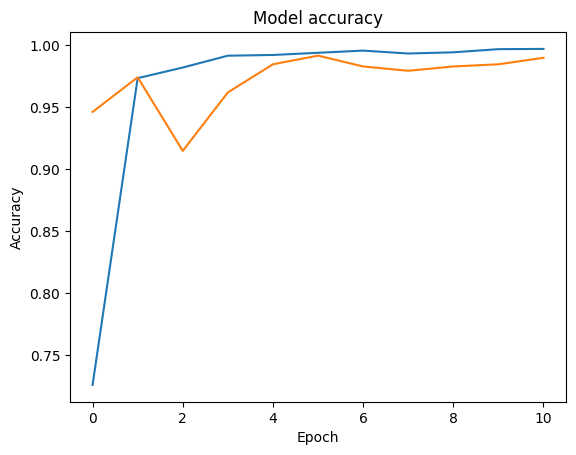

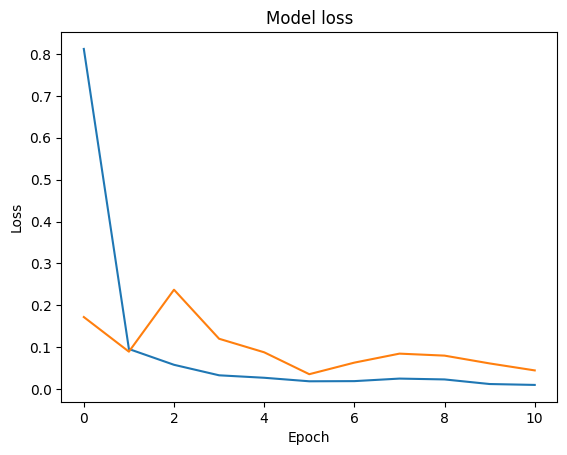

In [15]:
# Plot training & validation accuracy values
plt.plot(historyCNN.history['acc'], label = 'train')
plt.plot(historyCNN.history['val_acc'], label = 'test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(historyCNN.history['loss'], label = 'train')
plt.plot(historyCNN.history['val_loss'], label = 'test')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluation of model

Evaluation is done using the Evaluator object, which can be instanciated with test dataset (X_test the images and y_test the labels).
Prediction can be made with a model saved during the training phase by providing its path.
Labels are inferred from prediction probabilities using the argmax function, only when the max probability is >  0.7.
Otherwise label 0 (error) is assigned, meaning the model cannot make a reliable prediction.

The Evaluator object can then perform correction method, called by specifying correct labels and test labels to compare them to.
Labels are stored in Evaluator in the label attribute which is a dictionnary. In the correction method, confusion matrix and accuracy are calculated
using scikit learn API.

Following method metrics_calculation can be called to calculate custom metrics. We calculate these metrics to have a per label view of false positives and false negatives. This is important since in our model, we want to minimize false positive more importantly than minimizing false negative.
* False positives = symbols labelled correct while they are:
  * an error : FP_error
  * or a different symbol : FP_symbol
* False negative = symbols which are correct but are labelled as:
  * an error : FN_error
  * or a different symbol: FN_symbol

To evaluate the model, we use the test with the errors (0).

## Dense Neural Network

In [17]:
evaDNN = evaluate.Evaluator(X_test, y_test)
print(evaDNN.X.shape)
print(evaDNN.labels['train_labels'].shape)

(764, 28, 28)
(764,)


In [18]:
evaDNN.predict(modelpath = "models/DNN_26-0.848_20240602.keras")
print(evaDNN.labels['predicted_labels'].shape)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(764,)


In [19]:
evaDNN.correction(correct_labels = evaDNN.labels['train_labels'], test_labels = evaDNN.labels['predicted_labels'])
evaDNN.metrics_calculation()


metrics calculation


Accuracy : 0.5706806282722513, errors : 0.4293193717277487


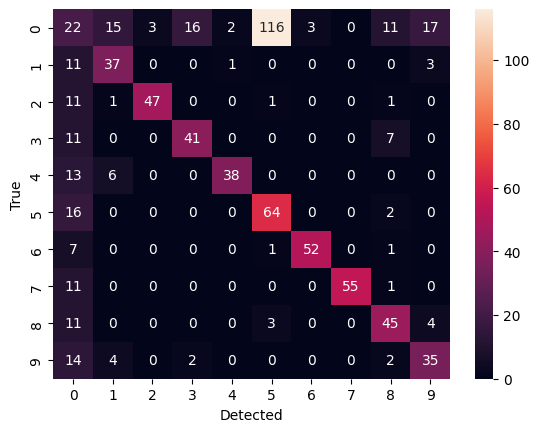

In [20]:
evaDNN.cm_plot()
print(f'Accuracy : {evaDNN.g_accuracy}, errors : {evaDNN.g_error}')

,0,1,2,3,4,5,6,7,8,9
Precision,0.173228,0.587302,0.940000,0.694915,0.926829,0.345946,0.945455,1.000000,0.642857,0.593220
Recall,0.107317,0.711538,0.770492,0.694915,0.666667,0.780488,0.852459,0.820896,0.714286,0.614035


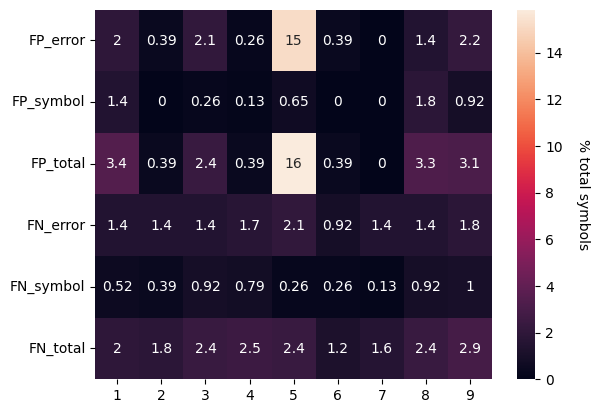

In [21]:
evaDNN.metrics_plot()
evaDNN.metrics_df()

## Convolutive Neural Network

In [49]:
evaCNN = evaluate.Evaluator(x_val, y_val)
print(evaCNN.X.shape)
print(evaCNN.labels['train_labels'].shape)
evaCNN.predict(modelpath = "models/CNN_11-0.991.keras")
print(evaCNN.labels['predicted_labels'].shape)

(573, 28, 28, 1)
(573,)
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(573,)


In [50]:
evaCNN.correction(correct_labels = evaCNN.labels['train_labels'], test_labels = evaCNN.labels['predicted_labels'])
evaCNN.metrics_calculation()

metrics calculation


C:\Users\Utilisateur\Documents\Stage\TREC - Codage\trec-coding\evaluate.py:63: RuntimeWarning: invalid value encountered in scalar divide
  self.recall = [self.cm[i, i] / self.cm[i, :].sum() for i in range(0,10)]


Accuracy : 0.9860383944153578, errors : 0.013961605584642212


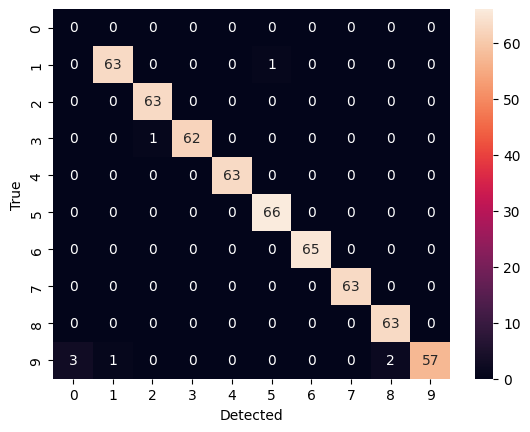

In [51]:
evaCNN.cm_plot()
print(f'Accuracy : {evaCNN.g_accuracy}, errors : {evaCNN.g_error}')

,0,1,2,3,4,5,6,7,8,9
Precision,0.0,0.984375,0.984375,1.000000,1.0,0.985075,1.0,1.0,0.969231,1.000000
Recall,NaN,0.984375,1.000000,0.984127,1.0,1.000000,1.0,1.0,1.000000,0.904762


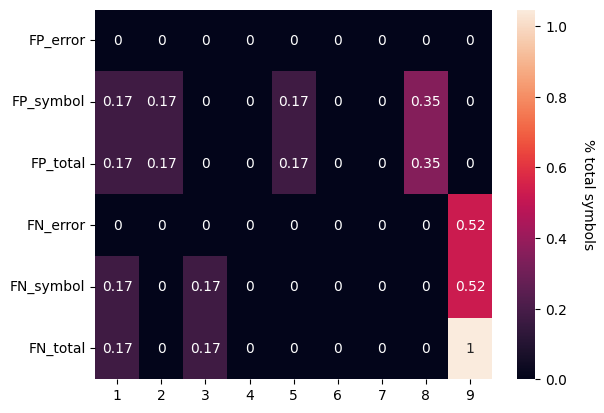

In [52]:
evaCNN.metrics_plot()
evaCNN.metrics_df()